<a href="https://colab.research.google.com/github/MasterDiaz410/Tarea2SL1/blob/master/Tarea2_SL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

La tarea práctica consiste en usar el mismo dataset del proyecto del curso pasado y e implementar gradient descent aplicado a regresión con este(usando la variable con mayor correlación elegida en el proyecto en anterior(solo una de las 2 del proyecto)),si no terminaron el proyecto anterior no se preocupen, no hay que hacer todo el proyecto, solo el entrenamiento con gradient descent pero usando tensorflow y usar tensorboard para monitorear que el error disminuya conforme avanzan las iteraciones "en vivo"(en lugar de hacerlo con matplotlib hasta el final como lo hicimos antes).
Pueden usar el siguiente ejemplo de regresión con tensorflow: https://www.geeksforgeeks.org/linear-regression-using-tensorflow/ o el notebook usado en clase.
Para la parte de Tensorboard, este nos permite visualizar mucha información relevante, pero nos centraremos en 2 cosas :

La curva de aprendizaje(disminución de error MSE en el tiempo)(en la la pestaña "scalars")
El grafo que representa a nuestro modelo (en la pestaña "graphs")

Requisitos:

- Utilizar solo operaciones vectorizadas.
- Usar BATCH gradient descent (utilizar todo el dataset en cada paso de gradient descent)
- Utilizar tensorboard:
- Agregar el grafo del modelo.
- Usar operaciones con nombre y usar name_spaces para mejorar el orden.
- Agregar un summary.scalar para monitorear el MSE.
- Aplicar reutilización de código: por ejemplo usar programación orientada a objetos para crear el modelo y/o definir el entrenamiento dentro de funciones de python.
- Utilizar las funciones reutilizables de entrenamiento para ejecutar al menos 10 experimentos (variable numero de iteraciones, y diferente learning rate)
- definir un string de configuración para cada experimento.
- crear un directorio para cada experimento basado en el string de configuración.
- utilizar un enfoque investigación científica: antes del experimento formular una hipótesis del comportamiento experado, ejecutar el experimento y utilizar los resultados de tensorboard para conculir.
- basado en los resultados experimentales obtenidos con tensorboard crear una conclusión general y elegir el mejor experimento.
- agregar el contenido de tensorboard al notebook.
- subir el notebook a github y agregar al GES el link
- no utilizar tf.train.GradientDescentOptimizer

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [4]:
# carga de informacion del archivo de entrada
dataOrigin = np.load('/content/drive/My Drive/Colab Notebooks/proyecto_training_data.npy')

# Cantidad de datos en entrenamiento y validacion 80 - 20
totalTriningData=int(0.8 * dataOrigin.shape[0])
totalValidationData=int(0.2 * dataOrigin.shape[0])

print("Total de datos de entrenamiento", totalTriningData)
print("Total de datos de validacion", totalValidationData)


Total de datos de entrenamiento 1168
Total de datos de validacion 292


In [5]:
# creamos los dataframes de entrenamiento y validacion
dfTrainingData = pd.DataFrame(dataOrigin[:totalTriningData])
dfValidationData = pd.DataFrame(dataOrigin[totalTriningData:])

# nombre de las columnas de dataframe
dfTrainingData.columns = ["SalesPrice", "Overall", "Floor", "Rooms", "Year", "Front"]
dfValidationData.columns = ["SalesPrice", "Overall", "Floor", "Rooms", "Year", "Front"]

# visualizamos su correlacion para elegir la feature que mejor describe al label
dfTrainingData.corr()


,SalesPrice,Overall,Floor,Rooms,Year,Front
SalesPrice,1.000000,0.793990,0.616289,0.564707,0.534171,0.363292
Overall,0.793990,1.000000,0.469411,0.444293,0.567313,0.242420
Floor,0.616289,0.469411,1.000000,0.409318,0.292074,0.417388
Rooms,0.564707,0.444293,0.409318,1.000000,0.122911,0.341005
Year,0.534171,0.567313,0.292074,0.122911,1.000000,0.121474
Front,0.363292,0.242420,0.417388,0.341005,0.121474,1.000000


Debido a la mayor correlacion que existe entre overall y sales price (0.793930), esta es la variable que se seleccionara para realizar las predicciones.

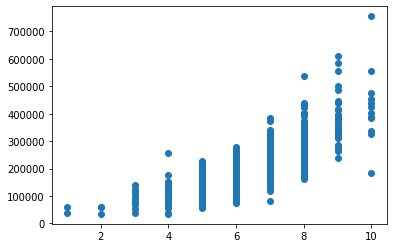

In [15]:
# definiendo los tensores

dfOverall = pd.DataFrame({ "Overall":dfTrainingData["Overall"], "Ones":np.ones_like(dfTrainingData["Overall"]),})
tfSalesPrice = tf.constant(dfTrainingData["SalesPrice"], tf.float32)
tfSalesPrice = tf.reshape(tfSalesPrice,[totalTriningData,1])
tfOverall = tf.constant(dfOverall, tf.float32)
tfParameters = tf.Variable(tf.random.normal([2,1]))


dfOverallnoOnes = pd.DataFrame({ "Overall":dfTrainingData["Overall"],})
X = tf.constant(dfOverallnoOnes, tf.float32)
Y = tfSalesPrice

# grafica de relacion entre overall X y Sales Price Y
with tf.Session() as sess:       
  # Initializing the Variables 
  plt.scatter(sess.run(X), sess.run(Y))
  plt.show()

In [40]:
# seccion para validar si el modelo planteado posteriormente nos brinda la solucion correcta
# Construyendo el modelo
c = 0
L = 0.0001  # The learning Rate
epochs = 1000  # The number of iterations to perform gradient descent
n = totalTriningData # Number of elements in X

Y_pred = m * X + c

# realizando el Gradient Descent 
for i in range(epochs):     
    
    #D_m = (-2/n) * sum(X * (Y - Y_pred))  # Derivative wrt m
    D_m = (-2/n) * tf.math.reduce_sum(X*(Y-Y_pred))
    D_c = (-2/n) * tf.math.reduce_sum(Y - Y_pred)  # Derivative wrt c
    m = m - L * D_m  # Update m
    c = c - L * D_c  # Update c
    
print (m, c)

Tensor("sub_31006:0", shape=(), dtype=float32) Tensor("sub_31007:0", shape=(), dtype=float32)


In [41]:
# definamos unas funciones utiles que nos apoyaran a encontrar nuestros valores

# funcion que genera la salida de una regresion lineal
def linearRegression(variables,parameters):
  return tf.convert_to_tensor(tf.matmul(variables,parameters), dtype=tf.float32)

# retorna el valor de costo de nuestro modelo
def costFunction(yreal,yprediccion,set_size):
  return tf.reduce_sum(tf.pow(yreal - yprediccion, 2) / (2 * set_size))

# calculo del vector gradiente para encontrar nuestros weights
def gradientVector(lr,totalElements, vectorParametrosMB):

    w0=tfParameters[0] - tf.multiply(tf.divide(lr,totalElements),
                              tf.reduce_sum(tf.multiply(yhat-tfSalesPrice,tfOverall)))

    w1=tfParameters[1] - tf.multiply(tf.divide(lr,totalElements),
                              tf.reduce_sum(yhat - tfSalesPrice))
    
    return (w0,w1)

In [42]:
# ahora usemos nuestras funciones para calcular nuestra estimacion
yhat = linearRegression(tfOverall,tfParameters)
print("yhat")
print(yhat)

# nuestra funcion de costo
cost = costFunction(tfSalesPrice, yhat, totalTriningData)
print("Costo")
print(cost)

yhat
Tensor("MatMul_2:0", shape=(1168, 1), dtype=float32)
Costo
Tensor("Sum_10000:0", shape=(), dtype=float32)


Planteamiento del problema, tratamos de validar el modelo que mejor se acople a nuestros datos y que los represente de mejor forma. Para ello seleccionamos la variable que mayor correlacion posee con las ventas la cual resulto ser overall. Ahora estamos generando modelos con diferentes lr (learning rates) y vemos como cada iteracion nos vamos acercando mas al resultado que obtuvimos en nuestro primer modelo realizando el gradient descent a mano. Ahora vamos a ver como se comportan los modelos.

In [ ]:
print(yreal)

In [45]:
# testeando las posibles soluciones 
def testingResults(i, lr):
  gradient = gradientVector(lr, totalTriningData, tfParameters)
  print("Iteracion " , i , " lr ", lr," w0 ",gradient[0] , " w1 ",gradient[1])


lr = 0.01
for i in range(10):
  testingResults(i, lr)
  lr = lr / 100


Iteracion  0  lr  0.01  w0  Tensor("sub_31014:0", shape=(1,), dtype=float32)  w1  Tensor("sub_31016:0", shape=(1,), dtype=float32)
Iteracion  1  lr  0.0001  w0  Tensor("sub_31018:0", shape=(1,), dtype=float32)  w1  Tensor("sub_31020:0", shape=(1,), dtype=float32)
Iteracion  2  lr  1e-06  w0  Tensor("sub_31022:0", shape=(1,), dtype=float32)  w1  Tensor("sub_31024:0", shape=(1,), dtype=float32)
Iteracion  3  lr  1e-08  w0  Tensor("sub_31026:0", shape=(1,), dtype=float32)  w1  Tensor("sub_31028:0", shape=(1,), dtype=float32)
Iteracion  4  lr  1e-10  w0  Tensor("sub_31030:0", shape=(1,), dtype=float32)  w1  Tensor("sub_31032:0", shape=(1,), dtype=float32)
Iteracion  5  lr  1e-12  w0  Tensor("sub_31034:0", shape=(1,), dtype=float32)  w1  Tensor("sub_31036:0", shape=(1,), dtype=float32)
Iteracion  6  lr  1e-14  w0  Tensor("sub_31038:0", shape=(1,), dtype=float32)  w1  Tensor("sub_31040:0", shape=(1,), dtype=float32)
Iteracion  7  lr  1e-16  w0  Tensor("sub_31042:0", shape=(1,), dtype=float32

Con cada iteracion nuestro modelo parece acercarse al punto w1, w2 (sub_31050,sub_31052) el cual vamos a dar por aceptado para este ejercicio.

